   ### Introduction
    The goal of the assignment is to implement a prototypical CBIR system. We recommend the use of the CalTech 101 image database http://www.vision.caltech.edu/Image_Datasets/Caltech101/. We recommend that you (for a start) select a subset of say 4-5 categories. When you have checked that everything works you may extend to say 20 categories. For each category, the set of images should be split in two: A training set and a test set (of equal size). The test set must not include images in the training set. When using few categories you may also limit the number of training images (to say 10) per category. Depending on your amount of computational power, for more categories, you may increase the number of training images to the double or more. You should extract visual words using SIFT descriptors (ignoring position, orientation and scale) or similar descriptors extracted at interest points. To compute the descriptors, we recommend to use OpenCV's sift, but other options are possible.

### Codebook Generation
    In order to generate a code book, select a set of training images. Then Extract SIFT features from the training images (ignore position, orientation and scale). The SIFT features should be concatenated into a matrix, one descriptor per row. Then you should run the k-means clustering algorithm on the subset of training descriptors to extract good prototype (visual word) clusters. A reasonable k should be small (say between 200 and 500) for a small number of categories (say 5) and larger (say between 500 and 2000) for a larger number of categories. Also, a good value of k may depend on the complexity of your data. You should experiment with a few di erent values of k (but beware that this can be rather time-consuming). Once clustering has been obtained, classify each training descriptor to the closest cluster centers) and form the bag of words (BoW) for each image in the image training set. Note that there may exist several implementations of k-means available in several libraries, e.g. in OpenCV and in scikit-image. These implementations may dffer both with respect to function, parameters and processing time.

  ### Indexing
    The next step consists in content indexing. For each image in the test set you
    should:
       
    a) Extract the SIFT descriptors of the feature points in the image
    b) Project the descriptors onto the codebook, i.e., for each descriptor the closest cluster prototype should be found
    c) Construct the generated corresponding bag of words, i.e, word histogram.

    Please note that you have already performed the same steps for the training images during codebook generation. Now construct and save a table that would contain, per entry at least the file name, the true category, if it belongs to the training- or test set, and the corresponding bag of words / word histogram. The table need only be computed once and then used repeatably in the following retrieval experiments.

### Retrieving
    Finally, you should implement retrieving of images using some of the similarity
    measures discussed in the course slides. You may use:
    
    a) common words
    b) tf-ifd similarity
    c) Bhattacharyya distance or Kullback-Leibler divergence
      
    Please argue for your choice or report the differences in result when applying the different measures. Your report should show commented results for two experiments. In the first you consider retrieving training images. In the second you test how well you can classify test images. Otherwise the two test are identical. For each test you should count:
    
    a) The mean reciprocal rank (i.e. the average across all queries of 1=ranki, where ranki is the rank position of the first correct category for the i'th query).
    b) How often (in per cent) the correct category is in top-3

    Please note that the measures above are just two among a long list of possible performance measures. If you google Information retrieval you may  find alternative measures.

    The report should be kept within 8 pages including everything. About half may show results in form of tables, graphs, and images. Remember to write what the tables and graphs should show. Important decisions, choices, and results should be discussed and explained. In particular, strage/false results should be identified and possible causes should be explained.

In [1]:
# Important packages
import os

import numpy as np
import random

import cv2
import skimage
from skimage.io import imread

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [11]:
# Loading 5 categories from the CALTECH101 corpus
def load_images(main_folder, n_categories):
    '''
    Loads images from multiple categories into one array.
    
    Arguments
    main_folder: folder where subfolders with categories exist
    n_categories: number of categories loaded
    
    Returns
    final_array: array with dimension (n_categories,) consisting of subarrays with images from each category
    cat: order of categories
    '''
    dr = os.listdir(main_folder)
    cat = dr[0:n_categories]
    all_images = []
    all_filenames = []

    for idx_cat, i in enumerate(cat):    
        tmp_path = os.path.join("101_ObjectCategories", i)
        tmp_images = np.array([imread(os.path.join(tmp_path, fname)) for fname in os.listdir(tmp_path) if fname.endswith('.jpg')])
        all_images.append(tmp_images)
        all_filenames.append(os.listdir(tmp_path))
        
    final_array = np.array(all_images)
    return final_array, cat, all_filenames
        
all_images, order, all_filenames = load_images("101_ObjectCategories", 5)        

<ipython-input-11-2d898c49b6a6>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp_images = np.array([imread(os.path.join(tmp_path, fname)) for fname in os.listdir(tmp_path) if fname.endswith('.jpg')])
<ipython-input-11-2d898c49b6a6>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_array = np.array(all_images)


In [12]:
# Balancing dataset and dividing into test and train 

def train_test_split(image_set, filenames, trainsize = 10, testsize = 5):
    # Sampling random numbers from the size of the image set
    all_elements = np.random.choice(len(image_set), trainsize+testsize, replace = False)

    train_elements = all_elements[:trainsize]
    test_elements = all_elements[-testsize:]
    
#    print(f"train is: {train_elements}")
#    print()
#    print(f"test is: {test_elements}")
    
    # Selecting the train elements
    train_images = image_set[train_elements]
    # Selecting filenames for train elements
    train_filenames = [filenames[k] for k in train_elements]
    
    # Selecting test elements
    test_images = image_set[test_elements]
    # Selecting filenames for test elements
    test_filenames = [filenames[k] for k in test_elements]
    
    return train_images, train_filenames, test_images, test_filenames

In [13]:
# from sklearn.model_selection import train_test_split
# gerenuk = all_images[0]

# Train test split
train = []
train_files = []
test = []
test_files = []

# Applying test_train split to every category
for image_set, filenames in zip(all_images, all_filenames):
    # train_images, train_filenames, test_images, test_filenames = train_test_split(image_set, filenames, test_size=0.5)
    train_images, train_filenames, test_images, test_filenames = train_test_split(image_set, filenames)
    train.append(train_images)
    train_files.append(train_filenames)
    test.append(test_images)
    test_files.append(test_filenames)
    
train = np.array(train)
train_files = np.array(train_files)

test = np.array(test)
test_files = np.array(test_files)

In [14]:
# Copied from https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html
test_img = train[0][0]

# Grayscale image
gray = cv2.cvtColor(test_img.copy(), cv2.COLOR_BGR2GRAY)

# Sift engine
sift = cv2.SIFT_create()

# Key points
kp = sift.detect(gray, None)

# Image with keypoints
img = cv2.drawKeypoints(gray, kp, test_img.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp, des = sift.compute(gray,kp)

In [15]:
def sift_descriptors(img):
    if len(img.shape) > 2:
            # Grayscale image
        gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
        # Sift engine
    sift = cv2.SIFT_create()
    # Key points
    kp = sift.detect(gray, None)
    # Image with keypoints
    # img = cv2.drawKeypoints(gray, kp, test_img.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    _ , des = sift.compute(gray, kp)

    return des


# The SIFT features should be concatenated into a matrix, one descriptor per row.
for set_idx, train_sets in enumerate(train):    
    for img in train_sets:
        des = sift_descriptors(img)        
        if set_idx == 0:
            descriptors = des
        else:
            #np.append(descriptors, des, axis=0)
            np.concatenate((descriptors, des), axis=0)
            #np.vstack((descriptors, des))

In [16]:
# Then you should run the k-means clustering algorithm on the subset of training descriptors to extract good prototype (visual word) clusters. 
# A reasonable k should be small (say b$etween 200 and 500) for a small number of categories (say 5) 
# and larger (say between 500 and 2000) for a larger number of categories. 
# Also, a good value of k may depend on the complexity of your data.

In [17]:
# Inspiration from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# Maybe use this link to demonstrate why scipy is nice https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html#comparison-of-high-performance-implementations
from scipy.cluster.vq import vq, kmeans, whiten

# Normalize (by standard deviation)
whitened = whiten(descriptors)
codebook, distortion = kmeans(whitened, 200)


# Assigns a code from a code book to each observation. 
# Each observation vector in the ‘M’ by ‘N’ obs array is compared with the centroids in the code book and assigned the code of the closest centroid.
# The code book is usually generated using the k-means algorithm. 
# Each row of the array holds a different code, and the columns are the features of the code.
# assigned_features = vq(whitened, codebook)

# whitened[:, 0], whitened[:, 1]
# is
# codebook[:, 0], codebook[:, 1]

In [18]:
print(whitened.shape)
print(descriptors.shape)
# Nice description: https://www.unioviedo.es/compnum/labs/new/kmeans.html

(1079, 128)
(1079, 128)


In [19]:
# vq returns:
# code - A length M array holding the code book index for each observation.
# dist - The distortion (distance) between the observation and its nearest code.
code_idx, dist = vq(whitened, codebook)

In [20]:
print(code_idx[0]) # Descriptor number 0 has prototype at codebook index 163 
codebook[code_idx[0]] # And that prototype looks like this 

25


array([0.4889616 , 0.69543386, 1.45159   , 1.1000012 , 0.6364229 ,
       0.57982343, 0.04306363, 0.11690954, 2.17945   , 2.0507686 ,
       1.3613172 , 0.43864712, 0.09089682, 0.18248282, 0.02478979,
       0.66794187, 2.8779128 , 3.1981156 , 0.94985706, 0.15061627,
       0.02907286, 0.03097591, 0.06593575, 0.43847957, 0.8959899 ,
       2.0850313 , 1.4816002 , 0.48651454, 0.16737556, 0.22939388,
       0.07788197, 0.2583497 , 1.2351855 , 0.23758113, 0.3577436 ,
       0.46742383, 0.57750994, 0.67192584, 0.30362055, 0.5355994 ,
       2.2455368 , 0.76658654, 0.57928056, 0.5549547 , 0.22424175,
       0.12566593, 0.02767654, 1.8135084 , 2.4166355 , 2.385576  ,
       1.618235  , 1.2658911 , 0.15308748, 0.02395133, 0.0301884 ,
       0.8834136 , 0.5119428 , 3.2357514 , 4.6520867 , 1.0205458 ,
       0.03184558, 0.00912236, 0.        , 0.0223719 , 0.8325831 ,
       0.19467787, 0.15211092, 0.37695575, 1.9616861 , 0.55588156,
       0.13232411, 0.38125077, 2.4081867 , 1.7019815 , 0.71747

In [21]:
# Indexing
# Now construct and save a table that would contain, per entry at least the file name, the true category, 
# if it belongs to the training- or test set, and the corresponding bag of words / word histogram. 
# The table need only be computed once and then used repeatably in the following retrieval experiments.

# Empty list for the bag of words / histograms
bow_train = []

# The SIFT features should be concatenated into a matrix, one descriptor per row.

# Going through all the train sets of each category
for set_idx, train_sets in enumerate(train): 
    # Print the category
    print(order[set_idx])
    
    # Going trhough each image in the category
    for img_idx, img in enumerate(train_sets):
        # Find descriptors
        des = sift_descriptors(img)
        # Whiten
        single_whit = whiten(des)
        # Find distribution of codes
        single_code_idx, _ = vq(single_whit, codebook)
        # Histogram
        #c = Counter(single_code_idx)
        imhist = np.zeros((codebook.shape[0]))
        for idx in single_code_idx:
            imhist[idx] += 1
            
        # saving a list with the group, the category, the filename and the histogram/bow
        l = ["train", order[set_idx], train_files[set_idx][img_idx], imhist]
    
        bow_train.append(l)

# Empty list for the bag of words / histograms        
bow_test = []       

for set_idx, test_sets in enumerate(test): 
    for img_idx, img in enumerate(test_sets):
        # Find descriptors
        des = sift_descriptors(img)
        # Whiten
        single_whit = whiten(des)
        # Find distribution of codes
        single_code_idx, _ = vq(single_whit, codebook)
        # Histogram
        imhist = np.zeros((codebook.shape[0]))
        # Histogram approach taken from https://github.com/JaggerWu/images-retrieving/blob/master/CodeBook_generation.py
        for idx in single_code_idx:
            imhist[idx] += 1
        #c = Counter(single_code_idx)
        
        l = ["test", order[set_idx], test_files[set_idx][img_idx], imhist]
        
        bow_test.append(l)

           

gerenuk
hawksbill
headphone
ant
butterfly


In [22]:
# Now we have a list with histograms of prototypes per train image 
bow_train = np.array(bow_train)
print(bow_train)

# Now we have a list with histograms of prototypes per test image 
bow_test = np.array(bow_test)
print(bow_test)

[['train' 'gerenuk' 'image_0004.jpg'
  array([ 1., 14.,  0., 19.,  4.,  9., 11.,  8.,  5., 27.,  4., 10.,  0.,
          1.,  5.,  0.,  3.,  4., 21.,  0.,  5.,  7.,  0.,  0., 16.,  4.,
          9.,  5., 22.,  0.,  0.,  3., 19.,  4.,  0.,  6.,  0.,  8.,  0.,
         18.,  0., 10., 17., 13.,  6.,  1.,  0.,  4.,  4.,  2., 11., 14.,
          0.,  4.,  0.,  8., 28.,  1., 10., 21., 22., 12., 20.,  1., 10.,
          0., 18.,  4.,  0.,  5., 12.,  0., 11.,  6., 13.,  0.,  8.,  5.,
          5.,  0.,  0.,  4., 19.,  1.,  0., 10.,  9., 11.,  1., 13.,  3.,
          0.,  1., 13.,  0.,  0.,  0., 14., 19.,  2.,  7.,  1., 14.,  3.,
         19., 11.,  6., 17.,  2.,  2.,  0.,  0.,  2.,  9.,  1.,  3., 10.,
          0.,  3., 24., 17.,  1., 15.,  5.,  1.,  7.,  9.,  0.,  6.,  9.,
          6.,  2., 14.,  5., 14.,  0.,  2.,  7., 10., 20.,  3.,  2.,  5.,
         14.,  1., 17.,  7.,  6., 13.,  0.,  0.,  0.,  0., 10.,  0.,  0.,
          3.,  0.,  4.,  7., 19.,  8.,  3.,  5.,  0.,  3.,  0., 12.,  4.,
 

<ipython-input-22-8f7a8f84a8f1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bow_train = np.array(bow_train)
<ipython-input-22-8f7a8f84a8f1>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bow_test = np.array(bow_test)


In [206]:
# from scipy.special import kl_div 
score = []
# kls = []

test_idx=6

# Distances 
test_hist = bow_test[test_idx]

for hist in bow_train:
    # compute the distance between the two histograms
    # using the method and update the results dictionary
    # kls.append(kl_div(test_hist[2], hist[2]))
    # Euclidean distance
    score.append(np.sqrt(sum((test_hist[3]-hist[3])**2)))

[147.55338017  42.23742416 105.41821474  44.47471192  52.69724851
  63.97655821  55.06359959  77.22046361  50.72474741 100.31450543
  43.9089968   54.29548784  53.33854141  37.97367509  42.81354926
  43.11612227  41.02438299  46.63689527  28.53068524  41.
  37.8153408   36.61966685  75.72978278  37.38983819  46.84015371
  41.31585652  31.81194744  34.84250278  42.77849927  42.81354926
  77.9166221   95.8801335   40.59556626  42.72001873  44.754888
  43.94314509  34.13209633  39.05124838  77.05193054  65.60487787
  52.35456045  65.20736155  50.17967716  45.04442252  34.33656943
  36.11094017  34.72751071  51.37119816  56.55970297  36.57868232]


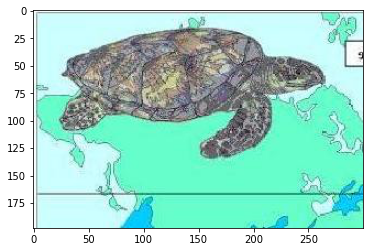

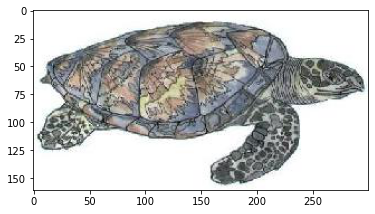

In [208]:
score = np.array(score)
print(score)

min_location = np.where(score == min(score))

query_img = imread(os.path.join("101_ObjectCategories", bow_test[test_idx][1], bow_test[test_idx][2]))
top = imread(os.path.join("101_ObjectCategories", bow_train[min_location][0][1], bow_train[min_location][0][2]))

plt.imshow(query_img)
plt.show()
plt.imshow(top)
plt.show()